In [1]:
import pandas as pd
import numpy as np
import os
import glob
import tempfile

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import col, explode, split, sum as spark_sum, countDistinct, collect_list, to_timestamp, lit, round
from pyspark.sql.types import StructType, StructField, StringType, IntegerType 

pyspark.__version__

'3.5.0'

In [2]:
spark = SparkSession.builder.config('spark.ui.port', 64053).appName("project1").getOrCreate()
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/18 06:27:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


DataFrame[key: string, value: string]

# Q1

In [3]:
# 文件路径
dir_dns = './Q1_data/dns/'
dir_http = './Q1_data/http/'
dns_files = os.listdir(dir_dns)
http_files = os.listdir(dir_http)
dns_files.sort()
http_files.sort()
print(dns_files, http_files)

['dns(0).log.gz', 'dns(1).log.gz', 'dns(2).log.gz', 'dns(3).log.gz', 'dns(4).log.gz', 'dns(5).log.gz'] ['http(0).log.gz', 'http(1).log.gz', 'http(2).log.gz', 'http(3).log.gz', 'http(4).log.gz', 'http(5).log.gz']


## （1）sort

In [3]:
from pyspark.sql.types import StructType, StructField, StringType, LongType, BooleanType, DoubleType,ArrayType
schema_dns = StructType([  
    StructField("AA", BooleanType(), True),  
    StructField("RA", BooleanType(), True),  
    StructField("RD", BooleanType(), True),  
    StructField("TC", BooleanType(), True),  
    StructField("TTLs", ArrayType(DoubleType(), True), True),  # 假设NULL字段对应NullType  
    StructField("Z", IntegerType(), True),  
    StructField("answers", ArrayType(StringType(), True), True),  # 假设NULL字段对应NullType  
    StructField("id.orig_h", StringType(), True),  
    StructField("id.orig_p", IntegerType(), True),  
    StructField("id.resp_h", StringType(), True),  
    StructField("id.resp_p", IntegerType(), True),  
    StructField("proto", StringType(), True),  
    StructField("qclass", IntegerType(), True),  
    StructField("qclass_name", StringType(), True),  
    StructField("qtype", IntegerType(), True),  
    StructField("qtype_name", StringType(), True),  
    StructField("query", StringType(), True),  
    StructField("rcode", IntegerType(), True),  
    StructField("rcode_name", StringType(), True),  
    StructField("rejected", BooleanType(), True),  
    StructField("rtt", DoubleType(), True),  # 假设NULL字段对应NullType  
    StructField("trans_id", IntegerType(), True),  
    StructField("ts", LongType(), True),  
    StructField("uid", StringType(), True),  
])
# 创建一个空的RDD  
empty_rdd = spark.sparkContext.emptyRDD()

In [5]:
df_dns = spark.createDataFrame(empty_rdd, schema_dns)# 依据schema生成空的df
sum_r = 0
for file in dns_files:
    tmp_df = spark.read.format("json")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(f'{dir_dns}{file}')
    sum_r += tmp_df.count()
    print(f'the file {file} has {tmp_df.count()} records')
    df_dns = df_dns.union(tmp_df)
    
print(f'the total records of 6 dns files is {sum_r}')
print(f'the df_dns has {df_dns.count()} records')

the file dns(0).log.gz has 14862 records
the file dns(1).log.gz has 8532 records
the file dns(2).log.gz has 6381 records
the file dns(3).log.gz has 902 records
the file dns(4).log.gz has 7422 records
the file dns(5).log.gz has 23684 records
the total records of 6 dns files is 61783
the df_dns has 61783 records


In [6]:
schema_http = StructType([
    StructField("host", StringType(), nullable=True),
    StructField("id.orig_h", StringType(), nullable=True),
    StructField("id.orig_p", LongType(), nullable=True),
    StructField("id.resp_h", StringType(), nullable=True),
    StructField("id.resp_p", LongType(), nullable=True),
    StructField("method", StringType(), nullable=True),
    StructField("orig_filenames", ArrayType(StringType()), nullable=True),
    StructField("orig_fuids", ArrayType(StringType()), nullable=True),
    StructField("orig_mime_types", ArrayType(StringType()), nullable=True),
    StructField("origin", StringType(), nullable=True),
    StructField("proxied", ArrayType(StringType()), nullable=True),
    StructField("referrer", StringType(), nullable=True),
    StructField("request_body_len", LongType(), nullable=True),
    # StructField("resp_filenames", ArrayType(StringType()), nullable=True),
    StructField("resp_fuids", ArrayType(StringType()), nullable=True),
    StructField("resp_mime_types", ArrayType(StringType()), nullable=True),
    StructField("response_body_len", LongType(), nullable=True),
    StructField("status_code", LongType(), nullable=True),
    StructField("status_msg", StringType(), nullable=True),
    StructField("tags", ArrayType(StringType()), nullable=True),
    StructField("trans_depth", LongType(), nullable=True),
    StructField("ts", DoubleType(), nullable=True),
    StructField("uid", StringType(), nullable=True),
    StructField("uri", StringType(), nullable=True),
    StructField("user_agent", StringType(), nullable=True),
    StructField("username", StringType(), nullable=True),
    StructField("version", StringType(), nullable=True)
])

In [7]:
df_http = spark.createDataFrame(empty_rdd, schema_http)# 依据schema生成空的df
sum_r = 0
for file in http_files:
    tmp_df = spark.read.format("json")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(f'{dir_http}{file}')
    sum_r += tmp_df.count()
    print(f'the file {file} has {tmp_df.count()} records')
    try:
        df_http = df_http.union(tmp_df)
    except:
        tmp_df = tmp_df.drop('resp_filenames') # 发现有两个文件的列比其他文件多一个
        df_http = df_http.union(tmp_df)
    
print(f'the total records of 6 http files is {sum_r}')
print(f'the df_http has {df_http.count()} records')

the file http(0).log.gz has 78194 records
the file http(1).log.gz has 12129 records


24/04/17 11:50:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


the file http(2).log.gz has 3815 records
the file http(3).log.gz has 3172 records


the file http(4).log.gz has 35063 records


the file http(5).log.gz has 53473 records
the total records of 6 http files is 185846


the df_http has 185846 records


In [8]:
# 转换ts为timestamp
df_dns = df_dns.withColumn('ts', to_timestamp(col('ts')))
df_http = df_http.withColumn('ts', to_timestamp(col('ts')))

In [9]:
# 生成临时表
df_dns.createOrReplaceTempView("dns_log")
df_http.createOrReplaceTempView("http_log")

## （2）

status code is 200 and method is GET, sort in a descending order according to the accessed count of the uri

### Spark.SQL

In [10]:
answer_sql = spark.sql("""
    SELECT uri, COUNT(*) AS accessed_count
    FROM http_log
    WHERE status_code = 200 AND method = 'GET'
    GROUP BY uri
    ORDER BY accessed_count DESC
        """)
answer_sql.show(5)

+--------------------+--------------+
|                 uri|accessed_count|
+--------------------+--------------+
|                   /|          9475|
|/admin/config.php...|           556|
|  /main.php?logout=1|           194|
|/top.php?stuff=15...|           191|
|            /top.php|           179|
+--------------------+--------------+
only showing top 5 rows



In [11]:
answer_sql.count()

7369

### Spark.Dataframe

In [12]:
answer_df = df_http.filter((col("status_code") == 200) & (col("method") == "GET")) \
              .groupBy("uri") \
              .count() \
              .orderBy("count", ascending=False)
answer_df.show(10)
answer_df.count()

+--------------------+-----+
|                 uri|count|
+--------------------+-----+
|                   /| 9475|
|/admin/config.php...|  556|
|  /main.php?logout=1|  194|
|/top.php?stuff=15...|  191|
|            /top.php|  179|
|/main.php?stuff=1...|  172|
|  /get_latest_id.php|  159|
|/admin/config.php...|  138|
|    /cacti/index.php|  129|
|/en-US/api/messag...|  118|
+--------------------+-----+
only showing top 10 rows



7369

## (3) Use Spark SQL to join the `http_log` and `dns_log` tables by `uid` , and calculate the percentage of `proto=tcp` for each `uri` group found in taks

In [13]:
joined_table = spark.sql("""
        SELECT d.uid as uid, proto, uri
        FROM http_log h INNER JOIN dns_log d ON h.uid == d.uid
        WHERE status_code = 200 AND method = 'GET'
        """)
joined_table.count()

476

In [16]:
joined_table.createOrReplaceTempView('joined_table')

In [17]:
result_df = spark.sql("""
    SELECT uri,
           100 * SUM(CASE WHEN proto = 'tcp' THEN 1 ELSE 0 END) / COUNT(*) AS tcp_percentage
    FROM joined_table
    GROUP BY uri
    ORDER BY tcp_percentage DESC
""")
result_df.show(5)
result_df.count()

+--------------------+------------------+
|                 uri|    tcp_percentage|
+--------------------+------------------+
|/lib/exe/indexer....|             100.0|
|  /get_latest_id.php|16.666666666666668|
|                   /|16.541353383458645|
|/_vti_bin/_vti_au...| 11.11111111111111|
| /_vti_bin/shtml.exe| 11.11111111111111|
+--------------------+------------------+
only showing top 5 rows



84

### (4) Use Spark dataframe to calculate the percentage of different `method` in the `http log`. Also display the pie chart of different `status code` for each `method` .

In [16]:
method_cnt = df_http.groupBy("method").agg(F.count("*").alias("count")).orderBy('count', ascending=False)
method_perc = method_cnt.withColumn('percentage(%)', (col('count')/df_http.count())*100).orderBy('count', ascending=False)
method_perc.show(36)

+-----------+------+--------------------+
|     method| count|       percentage(%)|
+-----------+------+--------------------+
|        GET|136678|   73.54368670834992|
|       POST| 40184|  21.622203329638516|
|       HEAD|  4805|   2.585473994597678|
|    OPTIONS|  2388|  1.2849348385222175|
|       NULL|  1376|  0.7403979639055993|
|    CONNECT|    84| 0.04519871291284181|
|     SEARCH|    72|0.038741753925292985|
|   PROPFIND|    40| 0.02152319662516277|
|RPC_CONNECT|    35|0.018832797047017423|
|   GNUTELLA|    34|0.018294717131388354|
|        PUT|    23|0.012375838059468592|
|      TRACE|    23|0.012375838059468592|
|     DELETE|    22|0.011837758143839522|
|       some|    17|0.009147358565694177|
|     Secure|    17|0.009147358565694177|
|     NESSUS|    13|0.006995038903177901|
|      TRACK|    13|0.006995038903177901|
|   DESCRIBE|     4|0.002152319662516277|
|     EAILCX|     1|5.380799156290692E-4|
|     NVKHMY|     1|5.380799156290692E-4|
|       user|     1|5.380799156290

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
method_list = [row.method for row in method_cnt.select("method").collect()]
method_num = [row['count'] for row in method_cnt.select("count").collect()]
print(method_list, method_num)

['GET', 'POST', 'HEAD', 'OPTIONS', None, 'CONNECT', 'SEARCH', 'PROPFIND', 'RPC_CONNECT', 'GNUTELLA', 'PUT', 'TRACE', 'DELETE', 'some', 'Secure', 'NESSUS', 'TRACK', 'DESCRIBE', 'EAILCX', 'NVKHMY', 'user', 'PCKOIZ', 'KTGFFX', 'XORXZY', 'BXNTPG', 'OEDNGQ', 'FHGDMH', 'YVFUKU', 'EQAONR', 'WOIGAG', 'UIZUPR', 'FPANCV', 'JZUIPY', 'GATMQW', 'RDWWEM', 'MCPWYV'] [136678, 40184, 4805, 2388, 1376, 84, 72, 40, 35, 34, 23, 23, 22, 17, 17, 13, 13, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [20]:
for index,method in enumerate(method_list):
    tmp_df = df_http.select('status_code').where(col('method') == method).groupBy("status_code").agg(F.count("*").alias("count")).toPandas()
    tmp_df.fillna('empty code')
    tmp_df['percentage'] = (tmp_df['count']/method_num[index])*100
    # 绘制饼图 
    plt.figure(figsize=(20, 16))
    fig, ax = plt.subplots()
    wedges = ax.pie(tmp_df['percentage'])
    plt.subplots_adjust(left=0, right=0.8, top=0.6, bottom=0)
    ax.set_title(f'pie of status code when method = {method}')
    ax.axis('equal')

    labels_and_percentages = [f'{name}#{perc:.1f}%' for name, perc in zip(tmp_df['status_code'], tmp_df['percentage'])]
    legend1 = plt.legend(labels_and_percentages, title="status code", loc="upper right", bbox_to_anchor=(1, 1), fontsize=8)  
    ax.add_artist(legend1)
    # 保存图片
    save_path = f'./Q1_4_figures/{method}.png'
    plt.savefig(save_path)
    plt.close()
    print(f'{index+1}  method {method} saved SUCCESSFULLY')

1  method GET saved SUCCESSFULLY


2  method POST saved SUCCESSFULLY


3  method HEAD saved SUCCESSFULLY


4  method OPTIONS saved SUCCESSFULLY
5  method None saved SUCCESSFULLY


6  method CONNECT saved SUCCESSFULLY


7  method SEARCH saved SUCCESSFULLY


8  method PROPFIND saved SUCCESSFULLY


9  method RPC_CONNECT saved SUCCESSFULLY


10  method GNUTELLA saved SUCCESSFULLY


11  method PUT saved SUCCESSFULLY


12  method TRACE saved SUCCESSFULLY


13  method DELETE saved SUCCESSFULLY


14  method some saved SUCCESSFULLY


15  method Secure saved SUCCESSFULLY


16  method NESSUS saved SUCCESSFULLY


17  method TRACK saved SUCCESSFULLY


18  method DESCRIBE saved SUCCESSFULLY


19  method EAILCX saved SUCCESSFULLY


/tmp/ipykernel_1898008/3989182784.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


20  method NVKHMY saved SUCCESSFULLY


/tmp/ipykernel_1898008/3989182784.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 16))


21  method user saved SUCCESSFULLY


22  method PCKOIZ saved SUCCESSFULLY


23  method KTGFFX saved SUCCESSFULLY


24  method XORXZY saved SUCCESSFULLY


25  method BXNTPG saved SUCCESSFULLY


26  method OEDNGQ saved SUCCESSFULLY


27  method FHGDMH saved SUCCESSFULLY


28  method YVFUKU saved SUCCESSFULLY


29  method EQAONR saved SUCCESSFULLY


30  method WOIGAG saved SUCCESSFULLY


31  method UIZUPR saved SUCCESSFULLY


32  method FPANCV saved SUCCESSFULLY


33  method JZUIPY saved SUCCESSFULLY


34  method GATMQW saved SUCCESSFULLY


35  method RDWWEM saved SUCCESSFULLY


36  method MCPWYV saved SUCCESSFULLY


<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

In [21]:
method = 'Null'#特殊情况处理
tmp_df = df_http.select('status_code').where(col('method').isNull()).groupBy("status_code").agg(F.count("*").alias("count")).toPandas()
tmp_df.fillna('empty code')
tmp_df['percentage'] = (tmp_df['count']/method_num[4])*100
# 绘制饼图 
plt.figure(figsize=(20, 16))
fig, ax = plt.subplots()
wedges = ax.pie(tmp_df['percentage'])
plt.subplots_adjust(left=0, right=0.8, top=0.6, bottom=0)
ax.set_title(f'pie of status code when method = {method}')
ax.axis('equal')

labels_and_percentages = [f'{name}#{perc:.1f}%' for name, perc in zip(tmp_df['status_code'], tmp_df['percentage'])]
legend1 = plt.legend(labels_and_percentages, title="status code", loc="upper right", bbox_to_anchor=(1, 1), fontsize=8)  
ax.add_artist(legend1)
# 保存图片
save_path = f'./Q1_4_figures/{method}.png'
plt.savefig(save_path)
plt.close()
print(f'method {method} saved SUCCESSFULLY')

method Null saved SUCCESSFULLY


<Figure size 2000x1600 with 0 Axes>

## Q2

### (1)

In [4]:
import requests
from bs4 import BeautifulSoup
import json
import time
import re
from time import sleep

In [5]:
# Define a request header (to prevent anti-scraping)
headers = {
    'authority': 'curlconverter.com',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-language': 'zh-CN,zh;q=0.9,en;q=0.8,en-GB;q=0.7,en-US;q=0.6',
    'cache-control': 'max-age=0',
    'if-modified-since': 'Fri, 15 Jul 2022 21:44:42 GMT',
    'if-none-match': 'W/"62d1dfca-3a58"',
    'referer': 'https://curlconverter.com/',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Microsoft Edge";v="102"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Linux"',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-user': '?1',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36',
}

In [24]:
url = "https://paulgraham.com/articles.html"
response = requests.get(url, headers = headers)
print(response.status_code)#查看请求码是否正常

200


In [25]:
page = response.text
# 使用正则表达式提取链接中的 URL
urls = re.findall(r'<a\s+href="([^"]+)"', page)[9:-1]
sp_u1 = urls[-4][8::]
sp_u2 = urls[-3][8::]
urls[-4] = sp_u1
urls[-3] = sp_u2
urls.remove('sep.turbifycdn.com/ty/cdn/paulgraham/acl1.txt?t=1712593590&')
urls.remove('sep.turbifycdn.com/ty/cdn/paulgraham/acl2.txt?t=1712593590&')
special_url = ['sep.turbifycdn.com/ty/cdn/paulgraham/acl1.txt?t=1712593590&',
               'sep.turbifycdn.com/ty/cdn/paulgraham/acl2.txt?t=1712593590&']#特殊网站特殊处理

In [26]:
directory = "./paul_articles/"
i = 1

for url in urls:
    visit = f'https://paulgraham.com/{url}'
    response = requests.get(visit, headers = headers)
    page = response.text
    soup = BeautifulSoup(page, "html.parser")
    
    title = re.findall(r'<title>(.*?)</title>', page)[0].replace('/', '_')#将title中的/替换为_，避免对路径产生干扰

    # 找到包含正文的<font>标签  
    font_tag = soup.find('font', {'size': '2', 'face': 'verdana'})#抓取正文部分

    font_tag_prettify = font_tag.prettify()#将网页转为string处理

    context = font_tag_prettify.replace('\n', ' ').replace('<br/>', '\n').replace('<p>', '\n')#先去除多余的换行，再将分段码转为换行
    cleaned_text = re.sub(r'<[^>]*>', ' ', context)#去除html符号
    cleaned_text = re.sub(r'^\s*$\n', ' ', cleaned_text, flags=re.MULTILINE)#去除多余空白行
    # cleaned_text = re.sub(r'\[\s+(\d+)\s*\]', r'[\1]', cleaned_text)
    cleaned_text = re.sub(r' +', ' ', cleaned_text)#去除段落中多余的空格

    paragraphs = cleaned_text.strip().split("\n")

    # 遍历段落列表，去除每个段落前后的空格
    cleaned_paragraphs = [paragraph.strip() for paragraph in paragraphs]

    # 使用join()方法将清理后的段落重新组合成文本
    article = "\n\n".join(cleaned_paragraphs)

    # 接下来，你可以像之前那样写文件  
    file_path = os.path.join(directory, f"{title}.txt")  
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(title+'\n')
        file.write(article)
    print(f'{i} file: {title} ## url: {url} ## path: {file_path} saved SUCCESSFULLY')
    i = i+1

1 file: The Reddits ## url: reddits.html ## path: ./paul_articles/The Reddits.txt saved SUCCESSFULLY
2 file: How to Start Google ## url: google.html ## path: ./paul_articles/How to Start Google.txt saved SUCCESSFULLY
3 file: The Best Essay ## url: best.html ## path: ./paul_articles/The Best Essay.txt saved SUCCESSFULLY
4 file: Superlinear Returns ## url: superlinear.html ## path: ./paul_articles/Superlinear Returns.txt saved SUCCESSFULLY
5 file: How to Do Great Work ## url: greatwork.html ## path: ./paul_articles/How to Do Great Work.txt saved SUCCESSFULLY
6 file: How to Get New Ideas ## url: getideas.html ## path: ./paul_articles/How to Get New Ideas.txt saved SUCCESSFULLY
7 file: The Need to Read ## url: read.html ## path: ./paul_articles/The Need to Read.txt saved SUCCESSFULLY
8 file: What You (Want to)* Want ## url: want.html ## path: ./paul_articles/What You (Want to)* Want.txt saved SUCCESSFULLY
9 file: Alien Truth ## url: alien.html ## path: ./paul_articles/Alien Truth.txt saved

In [27]:
directory = "./paul_articles/"

In [28]:
for index,url in enumerate(special_url):# 处理两个特殊文件
    visit = f'https://{url}'
    response = requests.get(visit, headers = headers)
    page = response.text
    title = f'Chapter {index+1} of Ansi Common Lisp'
    article = re.sub(r'\n(?!\s)', ' ', page)
    file_path = os.path.join(directory, f"{title}.txt")  
    with open(file_path, 'w', encoding='utf-8') as file:
        file.write(title+'\n')
        file.write(article)
    print(f'{i} file: {title} ## url: {url} ## path: {file_path} saved SUCCESSFULLY')
    i += 1

221 file: Chapter 1 of Ansi Common Lisp ## url: sep.turbifycdn.com/ty/cdn/paulgraham/acl1.txt?t=1712593590& ## path: ./paul_articles/Chapter 1 of Ansi Common Lisp.txt saved SUCCESSFULLY
222 file: Chapter 2 of Ansi Common Lisp ## url: sep.turbifycdn.com/ty/cdn/paulgraham/acl2.txt?t=1712593590& ## path: ./paul_articles/Chapter 2 of Ansi Common Lisp.txt saved SUCCESSFULLY


### (2) Create a dataframe by reading from these `txt` files with pyspark. Each row only contains the sentences in one paragraph. Select paragraphs that are related to suggestions of `career planning`. You can read some examples to determine some key phrases or regrex expressions for filtering. Store all the filtered paragraphs in a `parquet file career_suggestions.parquet` . (This is an open task that `different answers are allowed`.)

In [30]:
schema_ph = StructType([  
    StructField("title", StringType(), False),
    StructField("paragraph", StringType(), False)  # 该字段不可以为null  
])
df_paragraph = spark.createDataFrame(empty_rdd, schema_ph) # 生成一个空表，用于拼接

In [10]:
files = os.listdir('./paul_articles/')
files.remove('Chapter 1 of Ansi Common Lisp.txt')
files.remove('Chapter 2 of Ansi Common Lisp.txt')

months = r'(January|February|March|April|May|June|July|August|September|October|November|December)'
year = r'\d{4}'
date_pattern = r'{} {}'.format(months, year)
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')
files.sort()
pattern = r'^[ \n]*$' # 只包含空格和换行
i = 1
cnt = 0
rabbish_lines = ['Want to start a startup? Get funded by Y Combinator .', 'Like to build things? Try Hacker News .']# 出现多次，似乎是广告信息
for file in files:
    path = f'./paul_articles/{file}'
    title = ''
    paragraphs = []
    
    with open(path, 'r', encoding='utf-8') as file:
        title = file.readline().strip()
        date = file.readline()
        if re.match(date_pattern, date) or (date.strip() in rabbish_lines):#判断是否为日期或垃圾信息，是则跳过
            ph = file.readline()
        else:
            ph = date

        while ph != '':
            if not re.match(pattern, ph): #判断为非空行
                paragraphs.append(ph.strip())
            ph = file.readline()
            
    titles = [title]*len(paragraphs)
    rdd = spark.sparkContext.parallelize(zip(titles, paragraphs))  
    tmp_df = rdd.toDF(["title", "paragraph"])
    cnt += tmp_df.count()
    df_paragraph = df_paragraph.union(tmp_df)
    
    print(f'{i} {title} Union SUCCESSFULLY \n {title} has {len(paragraphs)} paragraphs, tmp_df has {tmp_df.count()} records')
    i += 1

NameError: name 'df_paragraph' is not defined

In [32]:
print(df_paragraph.count(), cnt)

24/04/16 08:59:55 WARN DAGScheduler: Broadcasting large task binary with size 1633.1 KiB


9676 9676


In [20]:
# related words and phrases
keywords=[  
    "career development", "goal setting", "skill development", "career path", "professional growth", "personal development",  
    "career advancement", "education and training", "job search strategies", "networking", "mentorship", "resume building",  
    "interview preparation", "work-life balance", "career satisfaction", "long-term career goals", "career transition",  
    "continuing education", "self-assessment", "career exploration", "career planning", "career", "careers", "job",
    "jobs", "profession", "professions", "advancement", "Advancement", "Career", "Careers", "Job", "Jobs",
    "Profession", "Professions"
]

In [21]:
filter_pattern = r"\b(" + "|".join(keywords) + r")\b"

In [37]:
filtered_df = df_paragraph.filter(
    col('paragraph').rlike(filter_pattern)
)

In [38]:
filtered_df.show()
filtered_df.count()

24/04/16 09:55:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/04/16 09:55:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/04/16 09:55:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/04/16 09:55:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/04/16 09:55:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/04/16 09:55:29 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/04/16 09:55:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
24/04/16 09:58:16 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


+--------------------+--------------------+
|               title|           paragraph|
+--------------------+--------------------+
|             Be Good|It's one of the s...|
|Do Things that Do...|Another consultin...|
|Frighteningly Amb...|Some of the atten...|
|The Hardest Lesso...|I was talking rec...|
+--------------------+--------------------+



24/04/16 10:01:46 WARN DAGScheduler: Broadcasting large task binary with size 1898.5 KiB


4

In [ ]:
parquet_directory = "./career_suggestions.parquet"

### (3) Extract noun phrases of all articles with Spark user-defined-functions and count their frequencies. You can use the Spacy Package. Plot the word cloud map with wordcloud package for the noun phrases which have the top 40~50 highest frequencies (including both end).

In [16]:
import spacy  
from spacy.matcher import Matcher  
from collections import Counter  
from wordcloud import WordCloud  
import matplotlib.pyplot as plt 

In [21]:
# 加载Spacy英文模型  
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])  
  
# 创建一个Matcher对象  
matcher = Matcher(nlp.vocab)  
  
# 定义名词性短语的规则，这里我们使用名词短语的结构，例如名词短语可能是一个名词后跟一个或多个形容词或名词  
# 注意：这个规则很基础，可能无法捕获所有名词短语，你可以根据需要添加更多复杂的规则  
pattern = [{'POS': 'NOUN'}, {'POS': {'IN': ['ADJ', 'NOUN']}, 'OP': '*'}]  
matcher.add('NOUN_PHRASES', [pattern], on_match=None)

In [23]:
# 输入的文本
files = os.pardir('./paul_articles/')
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')

empty_pattern = r'^[ \n]*$' # 只包含空格和换行
rabbish_lines = ['Want to start a startup? Get funded by Y Combinator .', 'Like to build things? Try Hacker News .']# 出现多次，似乎是广告信息
for file in files:
    text = ""
    with open(path, 'r', encoding='utf-8') as file:
        title = file.readline().strip()
        date = file.readline()
        if re.match(date_pattern, date) or (date.strip() in rabbish_lines):#判断是否为日期或垃圾信息，是则跳过
            ph = file.readline()
        else:
            ph = date

        while ph != '':
            if not re.match(empty_pattern, ph): #判断为非空行
                text += ph
            ph = file.readline()

    # 处理文本  
    doc = nlp(text)  
    matches = matcher(doc)  

    # 提取名词短语并计数  
    noun_phrases = []  
    for match_id, start, end in matches:  
        span = doc[start:end]  
        noun_phrase = ' '.join([token.text for token in span]).strip()  
        noun_phrases.append(noun_phrase)  

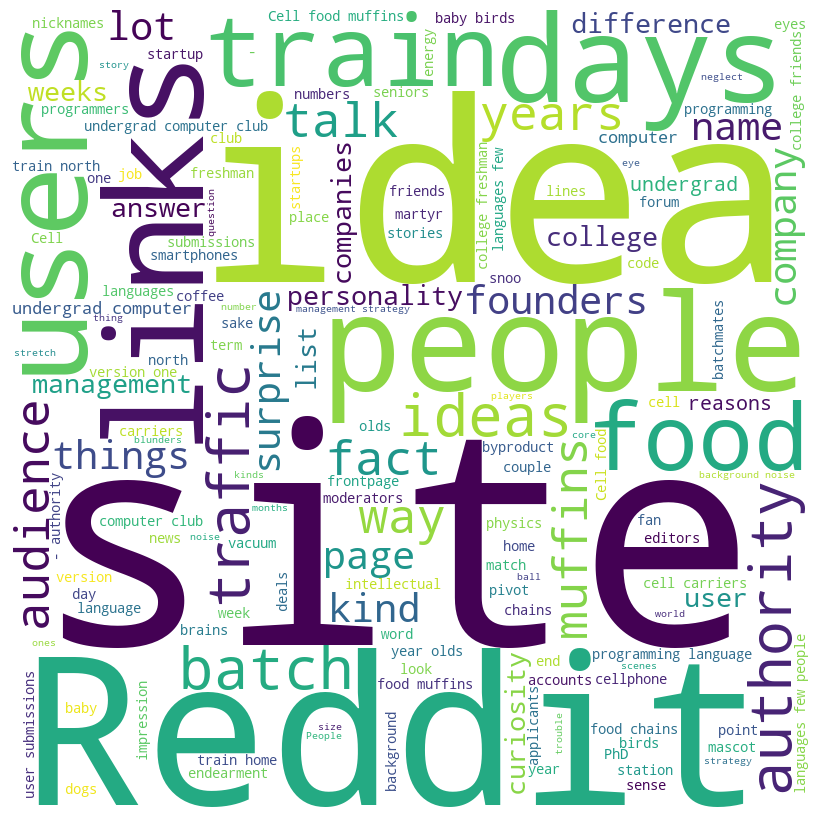

In [24]:
# 统计名词短语的数量  
noun_phrase_counts = Counter(noun_phrases)  
  
# 绘制词云  
wordcloud = WordCloud(width = 800, height = 800,   
                background_color ='white',    
                stopwords = None,   
                min_font_size = 10).generate_from_frequencies(noun_phrase_counts)  
  
# 显示词云图  
plt.figure(figsize = (8, 8), facecolor = None)   
plt.imshow(wordcloud)   
plt.axis("off")   
plt.tight_layout(pad = 0)   
plt.show()

In [35]:
# spark.stop()